# Semi-Supervised Deep Learning project
This notebook contains the Python code for the final project by the group "Uffe & Axel" in the 02456 Deep Learning course autumn 2020.

Cells responsible for training models will instead load model with provided filename if a matching filename is present. To override this and always execute training, set the following attribute to False.

In [1]:
use_saved_models = True

## Core

**IMPORTS**

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch import Tensor, nn
from torchvision.datasets import MNIST
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.transforms import ToTensor
from torch.distributions import Distribution
from torch.distributions import Bernoulli
from typing import Dict, Any
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
from collections import defaultdict
from IPython.display import Image, display, clear_output
import statistics
import math
import os.path
import socket
from torch.distributions import Categorical
# Static random seed
np.random.seed(89)

**LAMBDAS**

In [3]:
# Need to convert data to Tensor, because the DataLoader iterator refuses to work with PIL image objects.
pil2tensor = lambda x: ToTensor()(x).squeeze()   # ToTensor return (64,1,28,28), the squeeze() call removes the 1 dimension

# Binarize method for binarized dataset
binarize = lambda x: torch.bernoulli(x)

**DATASETS**

In [4]:
mnist_train_data = MNIST("./temp/", transform=pil2tensor, download=True, train=True)
mnist_test_data = MNIST("./temp/", transform=pil2tensor, download=True, train=False)

binarized_mnist_train_data = MNIST("./temp/",
                                   download=True,
                                   train=True,
                                   transform=transforms.Compose([pil2tensor,
                                                                 binarize]))
binarized_mnist_test_data = MNIST("./temp/",
                                  download=True,
                                  train=False,
                                  transform=transforms.Compose([pil2tensor,
                                                                binarize]))

**DATALOADERS**

In [5]:
def label_indices(dataset, total_labels):
    # return random list of indicies into 'dataset' that point to an equal amount of each label 0 to 9
    idx_list = []
    for target in range(10):
        idx_list += random.sample(list(np.where([dataset.targets.numpy() == target])[1]), k=int(total_labels/10))
    return idx_list
for cnt, idx in enumerate(label_indices(binarized_mnist_train_data, 10)):
    assert cnt == binarized_mnist_train_data[idx][1]

In [6]:
def loader_setup(labelled_size = 10000,
                 unlabelled_size = None,    # None: 50k - lbl_size
                 validation_size = 10000,
                 test_size = None,          # None: use all 10k
                 batch_size = 64):
    '''Setup all data loaders, providing labelled, unlabelled, validation & test samples'''
    global binarized_mnist_train_loader_labelled
    global binarized_mnist_train_loader_unlabelled
    global binarized_mnist_train_loader_validation
    global binarized_mnist_test_loader
    if unlabelled_size == None:
        unlabelled_size = 50000 - labelled_size
    indices_train = np.arange(len(binarized_mnist_train_data)) # 60000

    labelled_idx = label_indices(binarized_mnist_train_data, labelled_size)
    unlabelled_idx = random.sample(list(np.setdiff1d(indices_train, labelled_idx)
                                       ), k=unlabelled_size)
    validation_idx = random.sample(list(np.setdiff1d(indices_train, 
                                                     np.concatenate((labelled_idx,unlabelled_idx)))
                                       ), k=validation_size)

    # Last, generate the dataloaders
    binarized_mnist_train_loader_labelled = DataLoader(binarized_mnist_train_data, 
                                                       batch_size = batch_size,
                                                       sampler = SubsetRandomSampler(labelled_idx))
    if unlabelled_size == 0:
        # The M2 trainer skips unlabelled training if train_loader is 'None'
        binarized_mnist_train_loader_unlabelled = None
    else:
        binarized_mnist_train_loader_unlabelled = DataLoader(binarized_mnist_train_data, 
                                                             batch_size = batch_size, 
                                                             sampler = SubsetRandomSampler(unlabelled_idx))
    binarized_mnist_train_loader_validation = DataLoader(binarized_mnist_train_data, 
                                                         batch_size = batch_size, 
                                                         sampler = SubsetRandomSampler(validation_idx))
    if test_size == None:
        test_size = len(binarized_mnist_test_data)  # 10000
    indices_test = np.arange(test_size)
    binarized_mnist_test_loader = DataLoader(binarized_mnist_test_data, 
                                             batch_size = 64, 
                                             sampler = SubsetRandomSampler(indices_test))

In [7]:
loader_setup(labelled_size=10000, 
             unlabelled_size=40000, 
             validation_size=10000)

In [8]:
# Non-binarized dataloader
indices_train = list(range(len(mnist_train_data))) # 60000
mnist_train_loader = DataLoader(mnist_train_data, 
                                batch_size = 64, 
                                sampler = SubsetRandomSampler(indices_train))

**REPARAMETERIZED DIAGONAL GUASSIAN**

In [9]:
# Implement reparameterized diagonal gaussian
class ReparameterizedDiagonalGaussian(Distribution):
    def __init__(self, mu: Tensor, log_sigma: Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        return self.mu + self.sigma*self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        from torch.distributions import Normal 
        return  Normal(loc=self.mu, scale=self.sigma).log_prob(z)

**NETWORK CONSTRUCTOR HELPER**

In [10]:
# Helper method for easier creation of FFNN's in accordance with provided specifications
def FF_NetworkConstructor(layers: [],
                          pre_batchnorm: bool,
                          hidden_batchnorm: bool,
                          hidden_activation: nn.ReLU(),
                          dropout_prob: float,
                          final_activation: None) -> nn.Sequential:
    constructor = []
    if pre_batchnorm:
        constructor.append(nn.BatchNorm1d(num_features = layers[0]))
    for i in range(len(layers) - 2):
        constructor.append(nn.Linear(in_features = layers[i],
                                     out_features = layers[i + 1]))
        constructor.append(hidden_activation)
        if hidden_batchnorm:
            constructor.append(nn.BatchNorm1d(num_features = layers[i + 1]))
        constructor.append(nn.Dropout(p=dropout_prob))
    
    constructor.append(nn.Linear(in_features = layers[-2], out_features = layers[-1]))
    if final_activation is not None:
        constructor.append(final_activation)
    result = nn.Sequential(*constructor)
    
    return result

**DATA ANALYSIS SUPPORT**

In [11]:
def confuse_matrix_update(predictions, labels, confusion_matrix):
    # Update 'confusion_matrix' according the the prodictions/labels vectors.
    # Confusion_matrix rows are actual labels, and columns predictions. E.g. row 0 
    # tells how the classifier predicted '0', (0,0) represents correct predictions, 
    # (0,1) is how many times a '0' was classified as a '1'
    for pre, lbl in zip(predictions, labels):
        confusion_matrix[lbl,pre] += 1
def confuse_matrix_accuracy(cm):
    return 0.0 if cm.sum() == 0 else cm.trace()/cm.sum()
if False:
    cm = np.zeros((10,10))
    pred=torch.tensor([2,9,8,6])
    lab =torch.tensor([2,9,8,4])
    confuse_matrix_update(pred,lab,cm)
    confuse_matrix_update(pred,lab,cm)
    print(cm, confuse_matrix_accuracy(cm))

In [12]:
def print_confuse_matrix(VAE, test_loader = None):
    # print confuse_matrix for 'VAE' which is assumed to have function 'classifier'
    # and variable 'device' indicating cpu or cuda.
    if test_loader == None:
        test_loader = binarized_mnist_test_loader
    confuse_matrix = np.zeros((10,10)).astype('int')
    for images_test,labels_test in test_loader:
        images_test = images_test.to(VAE.device)
        classifications = VAE.classifier(images_test.view(-1,28*28))
        preds = torch.argmax(classifications,1)
        confuse_matrix_update(preds, labels_test, confuse_matrix)
    print(confuse_matrix)
    print("Classifier accuracy: %.3f" % confuse_matrix_accuracy(confuse_matrix))

In [13]:
# Helper class to handle plotting of training progress
class Plotter:
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.valid_losses = []
        self.valid_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        
        self.train_loss_buffer = []
        self.train_labels_buffer = []
        self.train_preds_buffer = []
        self.valid_loss_buffer = []
        self.valid_labels_buffer = []
        self.valid_preds_buffer = []
        self.test_loss_buffer = []
        self.test_labels_buffer = []
        self.test_preds_buffer = []
    
    def append_train(self, loss: Tensor = None, preds: Tensor = None, targets: Tensor = None):
        if loss is not None:
            self.train_loss_buffer = np.append(self.train_loss_buffer, loss.cpu().detach().numpy())
        if preds is not None and targets is not None:
            self.train_labels_buffer = np.append(self.train_labels_buffer, targets)
            self.train_preds_buffer = np.append(self.train_preds_buffer, preds.cpu().detach().numpy())
    
    def append_valid(self, loss: Tensor = None, preds: Tensor = None, targets: Tensor = None):
        if loss is not None:
            self.valid_loss_buffer = np.append(self.valid_loss_buffer, loss.cpu().detach().numpy())
        if preds is not None and targets is not None:
            self.valid_labels_buffer = np.append(self.valid_labels_buffer, targets)
            self.valid_preds_buffer = np.append(self.valid_preds_buffer, preds.cpu().detach().numpy())
    
    def append_test(self, loss: Tensor = None, preds: Tensor = None, targets: Tensor = None):
        if loss is not None:
            self.test_loss_buffer = np.append(self.test_loss_buffer, loss.cpu().detach().numpy())
        if preds is not None and targets is not None:
            self.test_labels_buffer = np.append(self.test_labels_buffer, targets)
            self.test_preds_buffer = np.append(self.test_preds_buffer, preds.cpu().detach().numpy())

    def plot(self):
        # Train processing
        if len(self.train_loss_buffer) > 0:
            self.train_losses = np.append(self.train_losses, np.mean(self.train_loss_buffer))
            self.train_loss_buffer = []
        if len(self.train_preds_buffer) > 0 and len(self.train_labels_buffer) > 0:
            train_acc = accuracy_score(self.train_labels_buffer, self.train_preds_buffer)
            self.train_preds_buffer = []
            self.train_labels_buffer = []
            self.train_accuracies = np.append(self.train_accuracies, train_acc)
        # Valid processing
        if len(self.valid_loss_buffer) > 0:
            self.valid_losses = np.append(self.valid_losses, np.mean(self.valid_loss_buffer))
            self.valid_loss_buffer = []
        if len(self.valid_preds_buffer) > 0 and len(self.valid_labels_buffer) > 0:
            valid_acc = accuracy_score(self.valid_labels_buffer, self.valid_preds_buffer)
            self.valid_labels_buffer = []
            self.valid_preds_buffer = []
            self.valid_accuracies = np.append(self.valid_accuracies, valid_acc)
        # Test processing
        if len(self.test_loss_buffer) > 0:
            self.test_losses = np.append(self.test_losses, np.mean(self.test_loss_buffer))
            self.test_loss_buffer = []
        if len(self.test_preds_buffer) > 0 and len(self.test_labels_buffer) > 0:
            test_acc = accuracy_score(self.test_labels_buffer, self.test_preds_buffer)
            self.test_labels_buffer = []
            self.test_preds_buffer = []
            self.test_accuracies = np.append(self.test_accuracies, test_acc)
        
        # Display
        clear_output(wait=True)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
        ax = axs[0, 0]
        ax.set_title('Loss')
        ax.plot(self.train_losses, label = 'Training')
        ax.plot(self.valid_losses, label = 'Validation')
        ax.plot(self.test_losses, label = 'Test')
        ax.legend()
        
        ax = axs[0, 1]
        ax.set_title('Accuracy')
        ax.plot(self.train_accuracies, label = 'Training')
        ax.plot(self.valid_accuracies, label = 'Validation')
        ax.plot(self.test_accuracies, label = 'Test')
        ax.legend()
        
        plt.tight_layout()
        tmp_img = "tmp_ae_out.png"
        plt.savefig(tmp_img)
        plt.close(fig)
        display(Image(filename=tmp_img))
        
        if len(self.train_losses) > 0 and len(self.valid_losses) > 0 and len(self.test_losses) > 0:
            print("Training Loss: %.3f, Validation Loss: %.3f, Test Loss: %.3f" %
                  (self.train_losses[-1], self.valid_losses[-1], self.test_losses[-1]))
        if len(self.train_accuracies) > 0 and len(self.valid_accuracies) > 0 and len(self.test_accuracies) > 0:
            print("Training Accuracy: %.3f, Validation Accuracy: %.3f, Test Accuracy: %.3f" %
                  (self.train_accuracies[-1], self.valid_accuracies[-1], self.test_accuracies[-1]))

## Vanilla FFNN classifier

**FFNN IMPLEMENTATION**

In [14]:
# Define a classification model
class FFNN_Classifier(nn.Module):
    def __init__(self, input_shape: torch.Size, num_classes: int, hidden_shape: [], dropout_prob:float = 0.5) -> None:
        super(FFNN_Classifier, self).__init__()
        
        # Core params
        self.input_shape = input_shape
        self.observation_features = np.prod(input_shape)
        self.epoch = 0
        
        # Model construction
        model_shape = [self.observation_features]
        model_shape.extend(hidden_shape)
        model_shape.append(num_classes)
        self.model = FF_NetworkConstructor(layers = model_shape,
                                           pre_batchnorm = False,
                                           hidden_batchnorm = True,
                                           hidden_activation = nn.ReLU(),
                                           dropout_prob = dropout_prob,
                                           final_activation = nn.Sigmoid())
        
    def forward(self, x) -> Tensor:
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

**FFNN TRAINER**

In [15]:
class FFNN_Trainer:
    def __init__(self,
                 network: FFNN_Classifier,
                 train_set: DataLoader,
                 valid_set: DataLoader,
                 test_set: DataLoader):
        self.network = network
        self.train_set = train_set
        self.valid_set = valid_set
        self.test_set = test_set
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.001)
        self.plotter = Plotter()

    def train(self):
        self.network.train()
        for images, labels in self.train_set:
            self.optimizer.zero_grad()
            classifications = self.network(images)
            loss = self.criterion(classifications, labels)
            loss.backward()
            self.optimizer.step()
        self.network.epoch += 1
    
    def test(self):
        self.network.eval()
        
        for images, labels in self.train_set:
            classifications = self.network(images)
            loss = self.criterion(classifications, labels)
            self.plotter.append_train(loss, torch.argmax(classifications, 1), labels)
        
        for images, labels in self.valid_set:
            classifications = self.network(images)
            loss = self.criterion(classifications, labels)
            self.plotter.append_valid(loss, torch.argmax(classifications, 1), labels)
        
        for images, labels in self.test_set:
            classifications = self.network(images)
            loss = self.criterion(classifications, labels)
            self.plotter.append_test(loss, torch.argmax(classifications, 1), labels)
        
        self.plotter.plot()

## Standard VAE

**VAE IMPLEMENTATION**

In [16]:
# Summarize values per sample
def reduce(x: Tensor) -> Tensor:
    return x.view(x.size(0), -1).sum(dim=1)

In [17]:
# Implement VAE
class M1_VAE(nn.Module):
    def __init__(self, 
                 input_shape: torch.Size,
                 latent_features: int,
                 classes: int,
                 hidden_layers_encoder: [], 
                 hidden_layers_decoder: [],
                 hidden_layers_classifier: [],
                 dropout_prob: float = 0.5) -> None:
        super(M1_VAE, self).__init__()

        # Core parameters
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.classes = classes
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        # Having epochs here makes it possible to continue training, with correct epochs counting
        self.epochs_vae = 0
        self.epochs_class = 0
        self.class_criterion = nn.CrossEntropyLoss()
        
        # Constructing the encoder network
        encoder_shape = [self.observation_features]
        encoder_shape.extend(hidden_layers_encoder)
        encoder_shape.append(self.latent_features * 2)
        self.encoder = FF_NetworkConstructor(layers = encoder_shape,
                                             pre_batchnorm = False,
                                             hidden_batchnorm = True,
                                             hidden_activation = nn.ReLU(),
                                             dropout_prob = 0.0,
                                             final_activation = None)

        # Constructing the decoder network
        decoder_shape = [self.latent_features]
        decoder_shape.extend(hidden_layers_decoder)
        decoder_shape.append(self.observation_features)
        self.decoder = FF_NetworkConstructor(layers = decoder_shape,
                                             pre_batchnorm = False,
                                             hidden_batchnorm = True,
                                             hidden_activation = nn.ReLU(),
                                             dropout_prob = 0.0,
                                             final_activation = None)
        
        # Constructing the classifier network
        classifer_shape = [self.latent_features * 2]
        classifer_shape.extend(hidden_layers_classifier)
        classifer_shape.append(self.classes)
        self.classifier = FF_NetworkConstructor(layers = classifer_shape,
                                                pre_batchnorm = True,
                                                hidden_batchnorm = True,
                                                hidden_activation = nn.ReLU(),
                                                dropout_prob = dropout_prob,
                                                final_activation = nn.Sigmoid())
        
        if torch.cuda.is_available():
            self.device = "cuda:0"
            self.encoder.cuda()
            self.decoder.cuda()
            self.classifier.cuda()
        else:
            self.device = "cpu"
            self.encoder.cpu()
            self.decoder.cpu()
            self.classifier.cpu()
        
    # Encode input into posterior distribution
    def encode(self, x: Tensor) -> Distribution:
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        result = ReparameterizedDiagonalGaussian(mu, log_sigma)
        result.mu = result.mu.to(self.device)
        result.sigma = result.sigma.to(self.device)
        return result
    
    # Decode latent variables into reconstruction
    def decode(self, z: Tensor) -> Distribution:
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits=px_logits)
    
    # Get the prior distribution
    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        result = ReparameterizedDiagonalGaussian(mu, log_sigma)
        result.mu = result.mu.to(self.device)
        result.sigma = result.sigma.to(self.device)
        return result
    
    def classify(self, z: Tensor) -> Tensor:
        return self.classifier(z)
    
    # Sample from a provided distribution
    def sample(self, distribution: ReparameterizedDiagonalGaussian) -> Tensor:
        return distribution.rsample()
    
    # Compute the ELBO
    def elbo(self, prior: Distribution, posterior: Distribution, reconstruction: Distribution, x: Tensor, z: Tensor) -> float:
        tst = reconstruction.sample().to(self.device)
        x = x.to(self.device)
        z = z.to(self.device)
        x = x.view(x.size(0), -1)
        log_px = reduce(reconstruction.log_prob(x))
        log_pz = reduce(prior.log_prob(z))
        log_qz = reduce(posterior.log_prob(z))
        kl = log_qz - log_pz
        elbo = log_px - kl
        return elbo
    
    def class_loss(self, classifications: Tensor, labels: Tensor) -> float:
        return self.class_criterion(classifications.to(self.device), labels.to(self.device))
    
    def forward(self, x: Tensor) -> Dict[str, Any]:
        # Figure out where model currently is located and update 'self.device'. 
        # Makes it possible to dynamically move model between cpu and cuda, after it has been initialized.
        if next(self.parameters()).is_cuda:
            self.device = "cuda:0"
        else:
            self.device = "cpu"
        x = x.to(self.device)
        x = x.view(x.size(0), -1) # flatten the input
        qz = self.encode(x) # define the posterior q(z|x) / encode x into q(z|x)
        pz = self.prior(batch_size=x.size(0)) # define the prior p(z)
        z = qz.rsample() # sample the posterior using the reparameterization trick: z ~ q(z | x)
        px = self.decode(z) # define the observation model p(x|z) = B(x | g(z))
        #c = self.classify(torch.cat((qz.mu, qz.sigma), 1))
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}

**VAE TRAINER**

In [18]:
class VAE_Trainer:
    def __init__(self,
                 network:M1_VAE                 = None,
                 train_labelled:DataLoader      = None,
                 train_unlabelled:DataLoader    = None,
                 valid_data:DataLoader          = None,
                 test_data:DataLoader           = None):
        self.model            = network          if network          != None else M1_instance
        self.train_labelled   = train_labelled   if train_labelled   != None else binarized_mnist_train_loader_labelled
        self.train_unlabelled = train_unlabelled if train_unlabelled != None else binarized_mnist_train_loader_unlabelled
        self.valid_data       = valid_data       if valid_data       != None else binarized_mnist_train_loader_validation
        self.test_data        = test_data        if test_data        != None else binarized_mnist_test_loader
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.plotter = Plotter()
    
    def train_elbo(self):
        self.model.train()
        for images, labels in self.train_labelled:
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = -self.model.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
            loss.backward()
            self.optimizer.step()
        if self.train_unlabelled is not None:
            for images, labels in self.train_unlabelled:
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = -self.model.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
                loss.backward()
                self.optimizer.step()
        self.model.epochs_vae += 1
    
    def train_classification(self):
        if self.train_labelled is not None:
            self.model.train()
            for layer in self.model.encoder.children():
                for param in layer.parameters():
                    param.requires_grad = False
            for images, labels in self.train_labelled:
                outputs = self.model(images)
                self.optimizer.zero_grad()
                classifications = self.model.classify(torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1))
                loss = self.model.class_loss(classifications, labels)
                loss.backward()
                self.optimizer.step()
        self.model.epochs_class += 1
    
    def test_elbo(self):
        self.model.eval()
        losses = []
        i = 0
        for images, labels in self.train_labelled:
            outputs = self.model(images)
            loss = -self.model.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
            self.plotter.append_train(loss, None, None)
        
        if self.train_unlabelled is not None:
            for images, labels in self.train_unlabelled:
                outputs = self.model(images)
                loss = -self.model.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
                self.plotter.append_train(loss, None, None)

        for images, labels in self.valid_data:
            outputs = self.model(images)
            loss = -self.model.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
            self.plotter.append_valid(loss, None, None)

        for images, labels in self.test_data:
            outputs = self.model(images)
            loss = -self.model.elbo(outputs['pz'], outputs['qz'], outputs['px'], images, outputs['z']).mean()
            self.plotter.append_test(loss, None, None)

        self.plotter.plot()
        print("VAE Epochs: ", self.model.epochs_vae)
        print("Classification Epochs: ", self.model.epochs_class)
    
    def test_classification(self, plot_loss: bool = False):
        if self.train_labelled is not None:
            self.model.eval()
            losses = []
            i = 0
            for images, labels in self.train_labelled:
                outputs = self.model(images)
                classifications = self.model.classify(torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1))
                preds = torch.argmax(classifications, 1)
                if plot_loss:
                    loss = self.model.class_loss(classifications, labels)
                else:
                    loss = None
                self.plotter.append_train(loss, preds, labels)

            for images, labels in self.valid_data:
                outputs = self.model(images)
                classifications = self.model.classify(torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1))
                preds = torch.argmax(classifications, 1)
                if plot_loss:
                    loss = self.model.class_loss(classifications, labels)
                else:
                    loss = None
                self.plotter.append_valid(loss, preds, labels)

            for images, labels in self.test_data:
                outputs = self.model(images)
                classifications = self.model.classify(torch.cat((outputs['qz'].mu, outputs['qz'].sigma), 1))
                preds = torch.argmax(classifications, 1)
                if plot_loss:
                    loss = self.model.class_loss(classifications, labels)
                else:
                    loss = None
                self.plotter.append_test(loss, preds, labels)

            self.plotter.plot()
            print("VAE Epochs: ", self.model.epochs_vae)
            print("Classification Epochs: ", self.model.epochs_class)

## M2 VAE

**IMPLEMENTATION**

In [104]:
class M2_VAE(nn.Module):
    def __init__(self, 
                 input_shape: torch.Size,
                 output_shape: torch.Size,
                 latent_features: int,
                 classes: int,
                 hidden_layers_mu: [],
                 hidden_layers_sigma: [],
                 hidden_layers_classification: [],
                 hidden_layers_decoder: [],
                 dropout: float = 0.5):
        super(M2_VAE, self).__init__()
        
        # Core params
        #self.input_shape = input_shape
        self.output_shape = output_shape
        self.observation_features = np.prod(input_shape)
        self.output_features = np.prod(output_shape)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        self.register_buffer('classification_prior_params', torch.full(torch.Size([1, classes]), 1 / classes))
        self.classes = classes
        # Having epochs here makes it possible to continue training, with correct epochs counting
        self.epochs = 0
        
        # Cuda enabling
        if torch.cuda.is_available():
            self.use_cuda = True
            self.device = "cuda:0"
        else:
            self.use_cuda = False
            self.device = "cpu"
        
        # Classifier construction
        classifier_shape = [self.observation_features]
        classifier_shape.extend(hidden_layers_classification)
        classifier_shape.append(classes)
        self.classifier = FF_NetworkConstructor(layers = classifier_shape,
                                                pre_batchnorm = False,
                                                hidden_batchnorm = True,
                                                hidden_activation = nn.ReLU(),
                                                dropout_prob = dropout,
                                                final_activation = None)
        
        # Mu network construction
        #postclass_shape = [self.observation_features + classes]
        postclass_shape = [self.observation_features]
        postclass_shape.extend(hidden_layers_mu)
        postclass_shape.append(latent_features)
        self.mu_encoder = FF_NetworkConstructor(layers = postclass_shape,
                                                pre_batchnorm = False,
                                                hidden_batchnorm = True,
                                                hidden_activation = nn.ReLU(),
                                                dropout_prob = 0.0,
                                                final_activation = None)
        
        # Sigma network construction
        postclass_shape = [self.observation_features]
        postclass_shape.extend(hidden_layers_sigma)
        postclass_shape.append(latent_features)
        self.sigma_encoder = FF_NetworkConstructor(layers = postclass_shape,
                                                   pre_batchnorm = False,
                                                   hidden_batchnorm = True,
                                                   hidden_activation = nn.ReLU(),
                                                   dropout_prob = 0.0,
                                                   final_activation = None)
        
        # Decoder construction
        decoder_shape = [latent_features + classes]
        decoder_shape.extend(hidden_layers_decoder)
        decoder_shape.append(self.output_features)
        self.decoder = FF_NetworkConstructor(layers = decoder_shape,
                                             pre_batchnorm = False,
                                             hidden_batchnorm = True,
                                             hidden_activation = nn.ReLU(),
                                             dropout_prob = 0.0,
                                             final_activation = None)
        
        # Move networks to cuda if available
        if self.use_cuda:
            self.classifier.cuda()
            self.mu_encoder.cuda()
            self.sigma_encoder.cuda()
            self.decoder.cuda()

    def prior(self, batch_size: int = 1) -> Distribution:
        local_prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = local_prior_params.chunk(2, dim=-1)
        result = ReparameterizedDiagonalGaussian(mu, log_sigma)
        result.mu = result.mu.to(self.device)
        result.sigma = result.sigma.to(self.device)
        return result
    
    def classification_prior(self, batch_size: int = 1) -> Distribution:
        local_classification_prior_params = self.classification_prior_params.expand(batch_size, 
                                                                                    *self.classification_prior_params.shape[-1:])
        result = Categorical(probs = local_classification_prior_params)
        return result
    
    def classification_posterior(self, x: Tensor) -> Distribution:
        result = self.classifier(x)
        result = result.view(-1, self.classes)
        result = Categorical(logits = result)
        return result
    
    def classification_entropy(self, qy: Tensor) -> float:
        qy = qy * torch.log(qy)
        return -qy.sum(1)
        
    def encode(self, x: Tensor, y: Tensor = None) -> Tensor:
        #mu_in = torch.cat((x, y), 1)
        #mu = self.mu_encoder(mu_in)
        mu = self.mu_encoder(x)
        log_sigma = self.sigma_encoder(x)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def decode(self, z: Tensor, y: Tensor) -> Distribution:
        px_logits = self.decoder(torch.cat((z, y), 1))
        px_logits = px_logits.view(-1, *self.output_shape)
        return Bernoulli(logits = px_logits)
    
    def onehot(self, y: int):
        result = torch.zeros(y.shape[0], self.classes).to(self.device)
        for i in range(len(y)):
            result[i][y[i]] = 1
        return result
    
    def loss(self,
             px: Distribution, 
             py: Distribution, 
             pz: Distribution, 
             qy: Distribution, 
             qz: Distribution, 
             input_: Tensor,
             recon_target: Tensor,
             y: int, 
             z: Tensor,
             alpha: float,
             debug: bool = False) -> float:
        input_ = input_.to(self.device)
        recon_target = recon_target.to(self.device)
        z = z.to(self.device)
        input_ = input_.view(input_.size(0), -1)
        recon_target = recon_target.view(recon_target.size(0), -1)
        
        py_logprob = py.logits.to(self.device)
        
        # If labels are not provided, sample from classification posterior
        if y is None:
            #x2 = x.repeat(10,1)
            #y2 = torch.Tensor(0)
            #for i in range(10):
            #    y2 = torch.cat( (y2, torch.Tensor([i]).expand(x.shape[0])))
            #y2 = y2.to(self.device)
            #outputs = self.forward(x2, y2)
            #px_logprob = outputs['px'].log_prob(x2.view(10*x.shape[0],-1)).sum(dim=1).view(-1,10)
            #qz_logprob = outputs['qz'].log_prob(outputs['z']).sum(dim=1).view(-1, 10)
            #pz_logprob = outputs['pz'].log_prob(outputs['z']).sum(dim=1).view(-1, 10)
            px_logprob = torch.Tensor(0).to(self.device)
            qz_logprob = torch.Tensor(0).to(self.device)
            pz_logprob = torch.Tensor(0).to(self.device)
            for i in range(10):
                _y = torch.Tensor([i]).expand(input_.shape[0])
                outputs = self.forward(input_, _y)
                px_logprob = torch.cat((px_logprob, outputs['px'].log_prob(recon_target).sum(dim = 1).view(-1, 1)), 1)
                qz_logprob = torch.cat((qz_logprob, outputs['qz'].log_prob(outputs['z']).sum(dim = 1).view(-1, 1)), 1)
                pz_logprob = torch.cat((pz_logprob, outputs['pz'].log_prob(outputs['z']).sum(dim = 1).view(-1, 1)), 1)
            L = -(px_logprob + py_logprob + pz_logprob - qz_logprob)
            U = -(torch.mul(qy.probs, -L).sum(1) + self.classification_entropy(qy.probs))
            J = U
            return J
        else:
            y = y.to(self.device)
            y = y.view(-1, 1)
            px_logprob = px.log_prob(recon_target).sum(dim = 1).view(-1, 1).repeat(1, 10)
            qz_logprob = qz.log_prob(z).sum(dim = 1).view(-1, 1).repeat(1, 10)
            pz_logprob = pz.log_prob(z).sum(dim = 1).view(-1, 1).repeat(1, 10)
            L = -(px_logprob + py_logprob + pz_logprob - qz_logprob)
            J = L.gather(1, y)
            J_alpha = J - (alpha * qy.logits.gather(1, y))
            return J_alpha
    
    def forward(self, x: Tensor, y: int = None, debug: bool = False) -> Dict[str, Any]:
        x = x.to(self.device) # Move to cuda if applicable
        x = x.view(x.size(0), -1) # Flatten image input
        qy = self.classification_posterior(x) # Classification posterior q(y|x)
        py = self.classification_prior(batch_size = x.size(0)) # Classification prior p(y)
        pz = self.prior(batch_size=x.size(0)) # Prior p(z)
        if y is None: # If labels are not provided, sample from classification posterior
            try:
                y = qy.sample()
            except:
                print(self.classifier(x))
                raise Exception("QY sample error")
        
        y = y.to(self.device)
        y = y.int()
        y = self.onehot(y)
        qz = self.encode(x, y) # Approximate posterior q(z|x, y)
        z = qz.rsample() # Sample the posterior
        px = self.decode(z, y) # Reconstruction p(x|z, y) = B(x | g(z, y))
        
        return {'px': px, 'py': py, 'pz': pz, 'qy': qy, 'qz': qz, 'z': z}

**TRAINER**

In [110]:
class M2_VAE_Trainer:
    def __init__(self,
                 network:M2_VAE              = None,
                 train_labelled:DataLoader   = None,
                 train_unlabelled:DataLoader = None,
                 valid:DataLoader            = None,
                 test:DataLoader             = None,
                 labelled_ratio:int          = 1,
                 alpha:float                 = 0.1,
                 verbose:int                 = 0):
        self.model            = network          if network          != None else M2_instance
        self.train_labelled   = train_labelled   if train_labelled   != None else binarized_mnist_train_loader_labelled
        self.train_unlabelled = train_unlabelled if train_unlabelled != None else binarized_mnist_train_loader_unlabelled
        self.valid_data       = valid            if valid            != None else binarized_mnist_train_loader_validation
        self.test_data        = test             if test             != None else binarized_mnist_test_loader
        self.alpha = alpha
        self.training_data = defaultdict(list)
        self.validation_data = defaultdict(list)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-3)
        self.labelled_ratio = labelled_ratio
        self.plotter = Plotter()
    
    def train(self):
        self.model.train()
        if self.train_unlabelled is not None:
            labelled_iter = iter(self.train_labelled)
            for images, labels in self.train_unlabelled:
                self.optimizer.zero_grad()
                outputs = self.model(images, None)
                loss = self.model.loss(outputs['px'],
                                       outputs['py'],
                                       outputs['pz'],
                                       outputs['qy'],
                                       outputs['qz'],
                                       images,
                                       images,
                                       None,
                                       outputs['z'],
                                       self.alpha).mean()
                for i in range(self.labelled_ratio):
                    try:
                        img_lbl, lbl_lbl = next(labelled_iter)
                    except StopIteration:
                        labelled_iter = iter(self.train_labelled)
                        img_lbl, lbl_lbl = next(labelled_iter)
                    outputs = self.model(img_lbl, lbl_lbl)
                    loss += self.model.loss(outputs['px'],
                                            outputs['py'],
                                            outputs['pz'],
                                            outputs['qy'],
                                            outputs['qz'],
                                            img_lbl,
                                            img_lbl,
                                            lbl_lbl,
                                            outputs['z'],
                                            self.alpha).mean()
                loss.backward()
                self.optimizer.step()
        else:
            for images, labels in self.train_labelled:
                self.optimizer.zero_grad()
                outputs = self.model(images, labels)
                loss = self.model.loss(outputs['px'],
                                       outputs['py'],
                                       outputs['pz'],
                                       outputs['qy'],
                                       outputs['qz'],
                                       images,
                                       images,
                                       labels,
                                       outputs['z'],
                                       self.alpha).mean()
                loss.backward()
                self.optimizer.step()
        self.model.epochs += 1
    
    def test(self):
        self.model.eval()
        losses = []
        i = 0
        epoch_data = defaultdict(list)
        for images, labels in self.train_labelled:
            outputs = self.model(images, labels)
            loss = self.model.loss(outputs['px'],
                                   outputs['py'],
                                   outputs['pz'],
                                   outputs['qy'],
                                   outputs['qz'],
                                   images,
                                   images,
                                   labels,
                                   outputs['z'],
                                   self.alpha).mean()
            classifications = self.model.classifier(images.view(-1,28*28).to(self.model.device))
            preds = torch.argmax(classifications,1)
            self.plotter.append_train(loss, preds, labels)

        for images, labels in self.valid_data:
            outputs = self.model(images, labels)
            loss = self.model.loss(outputs['px'],
                                   outputs['py'],
                                   outputs['pz'],
                                   outputs['qy'],
                                   outputs['qz'],
                                   images,
                                   images,
                                   labels,
                                   outputs['z'],
                                   self.alpha).mean()
            classifications = self.model.classifier(images.view(-1,28*28).to(self.model.device))
            preds = torch.argmax(classifications,1)
            self.plotter.append_valid(loss, preds, labels)

        for images, labels in self.test_data:
            outputs = self.model(images, labels)
            loss = self.model.loss(outputs['px'],
                                   outputs['py'],
                                   outputs['pz'],
                                   outputs['qy'],
                                   outputs['qz'],
                                   images,
                                   images,
                                   labels,
                                   outputs['z'],
                                   self.alpha).mean()
            classifications = self.model.classifier(images.view(-1,28*28).to(self.model.device))
            preds = torch.argmax(classifications,1)
            self.plotter.append_test(loss, preds, labels)

        self.plotter.plot()
        print("Epochs: ", self.model.epochs)

## Stacked M1+M2

**IMPLEMENTATION**

In [98]:
class M1_M2_VAE(nn.Module):
    def __init__(self, 
                 input_shape: torch.Size,
                 classes: int, 
                 latent_features_M1: int,
                 latent_features_M2: int,
                 hidden_layers_M1_encoder: [],
                 hidden_layers_M1_decoder: [],
                 hidden_layers_M2_mu_encoder: [],
                 hidden_layers_M2_sigma_encoder: [],
                 hidden_layers_M2_classification: [],
                 hidden_layers_M2_decoder: [],
                 dropout: float):
        super(M1_M2_VAE, self).__init__()
        self.M1 = M1_VAE(input_shape = input_shape,
                         latent_features = latent_features_M1,
                         classes = classes, 
                         hidden_layers_encoder = hidden_layers_M1_encoder,
                         hidden_layers_decoder = hidden_layers_M1_decoder,
                         hidden_layers_classifier = [],
                         dropout_prob = dropout)
        self.M2 = M2_VAE(input_shape = latent_features_M1,
                         output_shape = input_shape,
                         latent_features = latent_features_M2,
                         classes = classes,
                         hidden_layers_mu = hidden_layers_M2_mu_encoder,
                         hidden_layers_sigma = hidden_layers_M2_sigma_encoder,
                         hidden_layers_classification = hidden_layers_M2_classification,
                         hidden_layers_decoder = hidden_layers_M2_decoder,
                         dropout = dropout)
        self.epochs_M1 = int(0)
        self.epochs_M2 = int(0)
    
    def loss_m1(self,
                images: Tensor,
                outputs: Dict[str, Any]) -> float:
        loss = -self.M1.elbo(outputs['pz_M1'],
                             outputs['qz_M1'],
                             outputs['px_M1'],
                             images,
                             outputs['z_M1']).mean()
        return loss
    
    def loss_m2(self,
                images: Tensor,
                labels: Tensor,
                outputs: Dict[str, Any],
                alpha: float) -> float:
        loss = self.M2.loss(outputs['px_M2'],
                            outputs['py_M2'],
                            outputs['pz_M2'],
                            outputs['qy_M2'],
                            outputs['qz_M2'],
                            outputs['z_M1'],
                            images,
                            labels,
                            outputs['z_M2'],
                            alpha).mean()
        return loss
    
    def forward(self, x: Tensor, y: int = None, debug: bool = False) -> Dict[str, Any]:
        M1_outputs = self.M1(x)
        M2_outputs = self.M2(M1_outputs['z'], y)
        return {'px_M1': M1_outputs['px'],
                'pz_M1': M1_outputs['pz'],
                'qz_M1': M1_outputs['qz'],
                'z_M1': M1_outputs['z'], 
                'px_M2': M2_outputs['px'],
                'py_M2': M2_outputs['py'],
                'pz_M2': M2_outputs['pz'],
                'qy_M2': M2_outputs['qy'],
                'qz_M2': M2_outputs['qz'],
                'z_M2': M2_outputs['z']}

**TRAINER**

In [99]:
class M1_M2_Trainer:
    def __init__(self,
                 network: M1_M2_VAE,
                 train_labelled:DataLoader   = None,
                 train_unlabelled:DataLoader = None,
                 valid:DataLoader            = None,
                 test:DataLoader             = None,
                 labelled_ratio:int          = 1,
                 alpha:float                 = 0.1):
        self.network          = network          if network          != None else M2_instance
        self.train_labelled   = train_labelled   if train_labelled   != None else binarized_mnist_train_loader_labelled
        self.train_unlabelled = train_unlabelled if train_unlabelled != None else binarized_mnist_train_loader_unlabelled
        self.valid_data       = valid            if valid            != None else binarized_mnist_train_loader_validation
        self.test_data        = test             if test             != None else binarized_mnist_test_loader
        self.alpha = alpha
        self.M1_optimizer = torch.optim.Adam(self.network.M1.parameters(), lr=1e-3, weight_decay=1e-3)
        self.M2_optimizer = torch.optim.Adam(self.network.M2.parameters(), lr=1e-3, weight_decay=1e-3)
        self.labelled_ratio = labelled_ratio
        self.M1_plotter = Plotter()
        self.M2_plotter = Plotter()
    
    def train_M1(self):
        self.network.M1.train()
        for images, labels in self.train_labelled:
            self.M1_optimizer.zero_grad()
            outputs = self.network(images, labels)
            loss = self.network.loss_m1(images, outputs)
            loss.backward()
            self.M1_optimizer.step()
        if self.train_unlabelled is not None:
            for images, labels in self.train_unlabelled:
                self.M1_optimizer.zero_grad()
                outputs = self.network(images, None)
                loss = self.network.loss_m1(images, outputs)
                loss.backward()
                self.M1_optimizer.step()
        self.network.epochs_M1 += 1
    
    def test_M1(self):
        self.network.M1.eval()
        i = 0
        for images, labels in self.train_labelled:
            outputs = self.network(images, labels)
            loss = self.network.loss_m1(images, outputs)
            self.M1_plotter.append_train(loss, None, None)
        if self.train_unlabelled is not None:
            for images, labels in self.train_unlabelled:
                outputs = self.network(images, labels)
                loss = self.network.loss_m1(images, outputs)
                self.M1_plotter.append_train(loss, None, None)
        for images, labels in self.valid_data:
            outputs = self.network(images, labels)
            loss = self.network.loss_m1(images, outputs)
            self.M1_plotter.append_valid(loss, None, None)
        for images, labels in self.test_data:
            outputs = self.network(images, labels)
            loss = self.network.loss_m1(images, outputs)
            self.M1_plotter.append_test(loss, None, None)
        self.M1_plotter.plot()
    
    def train_M2(self):
        self.network.M1.eval()
        self.network.M2.train()
        if self.train_unlabelled is not None:
            labelled_iter = iter(self.train_labelled)
            for images, labels in self.train_unlabelled:
                self.M2_optimizer.zero_grad()
                outputs = self.network(images, None)
                loss = self.network.loss_m2(images, None, outputs, self.alpha)
                for i in range(self.labelled_ratio):
                    try:
                        img_lbl, lbl_lbl = next(labelled_iter)
                    except StopIteration:
                        labelled_iter = iter(self.train_labelled)
                        img_lbl, lbl_lbl = next(labelled_iter)
                    outputs = self.network(img_lbl, lbl_lbl)
                    loss = self.network.loss_m2(img_lbl, lbl_lbl, outputs, self.alpha)
                loss.backward()
                self.M2_optimizer.step()
        else:
            for images, labels in self.train_labelled:
                self.M2_optimizer.zero_grad()
                outputs = self.network(images, labels)
                loss = self.network.loss_m2(images, labels, outputs, self.alpha)
                loss.backward()
                self.M2_optimizer.step()
        self.network.epochs_M2 += 1
    
    def test_M2(self):
        self.network.M2.eval()
        for images, labels in self.train_labelled:
            outputs = self.network(images, labels)
            loss = self.network.loss_m2(images, labels, outputs, self.alpha)
            #classifications = self.model.classifier(images.view(-1,28*28).to(self.model.device))
            classifications = outputs['qy_M2'].probs
            preds = torch.argmax(classifications,1)
            self.M2_plotter.append_train(loss, preds, labels)
        for images, labels in self.valid_data:
            outputs = self.network(images, labels)
            loss = self.network.loss_m2(images, labels, outputs, self.alpha)
            #classifications = self.model.classifier(images.view(-1,28*28).to(self.model.device))
            classifications = outputs['qy_M2'].probs
            preds = torch.argmax(classifications,1)
            self.M2_plotter.append_valid(loss, preds, labels)
        for images, labels in self.test_data:
            outputs = self.network(images, labels)
            loss = self.network.loss_m2(images, labels, outputs, self.alpha)
            #classifications = self.model.classifier(images.view(-1,28*28).to(self.model.device))
            classifications = outputs['qy_M2'].probs
            preds = torch.argmax(classifications,1)
            self.M2_plotter.append_test(loss, preds, labels)
        self.M2_plotter.plot()

In [100]:
loader_setup(labelled_size=100, unlabelled_size=40000)
epochs = 20
fn = "m1_m2_class_100_labelled_40k_unlabelled.pt"

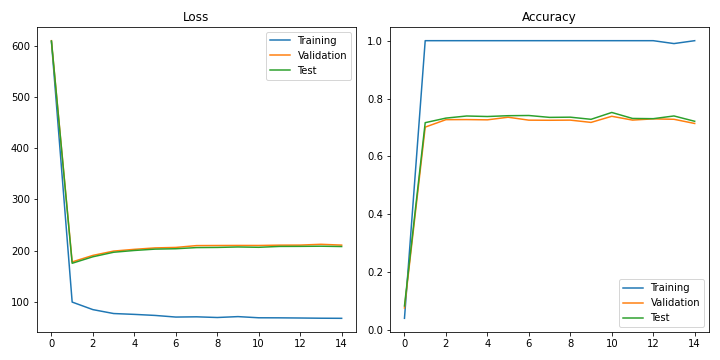

Training Loss: 67.510, Validation Loss: 210.603, Test Loss: 207.825
Training Accuracy: 1.000, Validation Accuracy: 0.714, Test Accuracy: 0.721


KeyboardInterrupt: 

In [103]:
%%time
# Instantiate VAE
sample = binarized_mnist_train_data.__getitem__(22)[0]
stacked_instance = M1_M2_VAE(sample.flatten().shape,
                             classes = 10,
                             latent_features_M1 = 50,
                             latent_features_M2 = 50,
                             hidden_layers_M1_encoder = [500],
                             hidden_layers_M1_decoder = [500],
                             hidden_layers_M2_mu_encoder = [500],
                             hidden_layers_M2_sigma_encoder = [500],
                             hidden_layers_M2_classification = [500],
                             hidden_layers_M2_decoder = [500],
                             dropout = 0.5)
# Instantiate trainer
stacked_trainer = M1_M2_Trainer(stacked_instance,
                                binarized_mnist_train_loader_labelled,
                                binarized_mnist_train_loader_unlabelled,
                                binarized_mnist_train_loader_validation,
                                binarized_mnist_test_loader,
                                5,
                                0.2)
# Training
M1_epochs = 20
M2_epochs = 20
stacked_trainer.test_M1()
for i in range(M1_epochs):
    stacked_trainer.train_M1()
    stacked_trainer.test_M1()
    
stacked_trainer.test_M2()
for i in range(M2_epochs):
    stacked_trainer.train_M2()
    stacked_trainer.test_M2()

# Execution

## Simple FF classifier

**FF 100 LABELLED - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size=100)
epochs = 50
fn = "ff_100_labelled.pt"

**FF 1K LABELLED - SETUP**

In [ ]:
dropout = 0.1
loader_setup(labelled_size=1000)
epochs = 50
fn = "ff_1k_labelled.pt"

**FF 10K LABELLED - SETUP**

In [ ]:
dropout = 0.3
loader_setup(labelled_size=10000)
epochs = 50
fn = "ff_10k_labelled.pt"

**FF 50K LABELLED - SETUP**

In [ ]:
dropout = 0.5
loader_setup(labelled_size=50000, validation_size=10000)
epochs = 50
fn = "ff_50k_labelled.pt"

**FF EXECUTE TRAINING/LOADING**

In [ ]:
%%time
sample = binarized_mnist_train_data.__getitem__(22)[0]
ffnn = FFNN_Classifier(sample.flatten().shape, 10, [500, 250], dropout_prob=dropout)
trainer = FFNN_Trainer(ffnn,
                       binarized_mnist_train_loader_labelled,
                       binarized_mnist_train_loader_validation,
                       binarized_mnist_test_loader)
if use_saved_models and os.path.isfile(fn):
    ffnn.load_state_dict(torch.load(fn))
    trainer.test()
    print("Model loaded from '%s'" % fn)
else:
    trainer.test()
    for i in range(epochs):
        trainer.train()
        trainer.test()
    torch.save(ffnn.state_dict(), fn)

## Standard VAE (M1)

**M1 100/0 LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 100, unlabelled_size = 0, validation_size = 10000)
fn = "m1_class_100_labelled_0_unlabelled.pt"
fn_base = None # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 100
epochs_classification = 100

**M1 100/100 LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 100, unlabelled_size = 100, validation_size = 10000)
fn = "m1_class_100_labelled_100_unlabelled.pt"
fn_base = None # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 100
epochs_classification = 100

**M1 100/1K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 100, unlabelled_size = 1000, validation_size = 10000)
fn = "m1_class_100_labelled_1k_unlabelled.pt"
fn_base = None # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 100
epochs_classification = 100

**M1 100/10K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 100, unlabelled_size = 10000, validation_size = 10000)
fn = "m1_class_100_labelled_10k_unlabelled.pt"
fn_base = None # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 100
epochs_classification = 100

**M1 VAE only training**

As we start exploring the potential of adding labelled observations to a latent space trained on 40k unlabelled observations, we just train a core VAE on the 40k observations and save it without doing any classification training. We then load that model and run classification trainings on it (model with trained classifier saved seperately).

In subsequent classification training, we omit unlabelled training.

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 0, unlabelled_size = 40000, validation_size = 10000)
fn = "m1_class_5_lspc.pt"
fn_base = None # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 200
epochs_classification = 0

**M1 100/40K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 100, unlabelled_size = 0, validation_size = 10000)
fn = "m1_class_100_labelled_40k_5_lspc.pt"
fn_base = "m1_class_5_lspc.pt" # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 0
epochs_classification = 70

**M1 1K/40K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 1000, unlabelled_size = 0, validation_size = 10000)
fn = "m1_class_1k_labelled_40k_5_lspc.pt"
fn_base = "m1_class_5_lspc.pt" # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 0
epochs_classification = 100

**M1 10K/40K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 10000, unlabelled_size = 0, validation_size = 10000)
fn = "m1_class_10k_labelled_40k_5_lspc.pt"
fn_base = "m1_class_5_lspc.pt" # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 0
epochs_classification = 100

**M1 50K/40K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
dropout = 0.0
loader_setup(labelled_size = 50000, unlabelled_size = 0, validation_size = 10000)
fn = "m1_class_50k_labelled_40k_5_lspc.pt"
fn_base = "m1_class_5_lspc.pt" # If fn_base is set, this filename identifies model with trained VAE part but untrained classifier
epochs_VAE = 0
epochs_classification = 15

**M1 EXECUTE TRAINING/LOADING**

In [ ]:
%%time
# Instantiate a VAE
sample = binarized_mnist_train_data.__getitem__(0)[0]
M1_instance = M1_VAE(sample.flatten().shape,
                      5, # Changed from 50
                      10,
                      [450, 250, 100],
                      [128, 256, 512],
                      [100, 80],
                      dropout_prob = dropout)
# Initialize trainer
trainer = VAE_Trainer(M1_instance,
                      binarized_mnist_train_loader_labelled,
                      binarized_mnist_train_loader_unlabelled,
                      binarized_mnist_train_loader_validation,
                      binarized_mnist_test_loader)
if use_saved_models and os.path.isfile(fn):
    M1_instance.load_state_dict(torch.load(fn))
    print("Loaded M1_instance model from %s" % fn)
else:
    if fn_base is not None:
        M1_instance.load_state_dict(torch.load(fn_base))
        print("Loaded M1_instance model from %s" % fn_base)
        trainer.test_classification(False)
    # Train the VAE
    for i in range(epochs_VAE):
        trainer.train_elbo()
        trainer.test_elbo()
    # Train the classifier
    for i in range(epochs_classification):
        trainer.train_classification()
        trainer.test_classification(False)
    torch.save(M1_instance.state_dict(), fn)

**M1 - 50 DIMENSIONAL LATENT SPACE**

This model is trained just to have a VAE model with higher dimensionality for comparative analysis of latent space behavior.

In [ ]:
%%time
M1_instance = M1_VAE(sample.flatten().shape,
                      50,
                      10,
                      [450, 250, 100],
                      [128, 256, 512],
                      [100, 80],
                      dropout_prob = 0.0)
loader_setup(labelled_size=0, unlabelled_size = 50000, validation_size = 10000, test_size=10000)
trainer = VAE_Trainer()
epochs_vae = 100
fn = "m1_class_50_lspc.pt"
if use_saved_models and os.path.isfile(fn):
    M1_instance.load_state_dict(torch.load(fn))
    print("Loaded M1_instance model from %s" % fn)
else:
    for i in range(epochs_vae):
        trainer.train_elbo()
        trainer.test_elbo()
    torch.save(M1_instance.state_dict(), fn)

## M1 - Exploration

Run any M1 configuration cell and the loading/training cell above to ensure that M1_instance references the desired model. Then run the cells below to generate visualizations.

**LATENT TRAVERSAL**

This is generally more "fun" on M1 models with fewer latent dimensions, where single planes are more likely to contain multiple clearly defined digits

In [ ]:
# Latent space traversal
x_dimension = 0
y_dimension = 1
traversal_speed = 1

M1_instance.eval()
fig, axs = plt.subplots(11, 11, figsize=(11, 11), squeeze=False)
z = torch.zeros(11, M1_instance.latent_features).cuda()
for i in range(11):
    z[i, x_dimension] = (i-5) * traversal_speed
for i in range(11):
    for j in range(11):
        z[j, y_dimension] = (i-5) * traversal_speed
    for j in range(11):
        image = M1_instance.decode(z[j].reshape(1, -1)).probs.view(28,28).cpu().detach().numpy()
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()

**LATENT VARIABLE DISTRIBUTIONS**

In [ ]:
loader_setup(labelled_size = 50000, unlabelled_size = 0)
M1_instance.eval()
mus = []
sigmas = []
for images, labels in binarized_mnist_train_loader_labelled:
    outputs = M1_instance(images)
    tmp = outputs['qz'].mu.cpu().detach().numpy()
    mus.extend(tmp)
    tmp = outputs['qz'].sigma.cpu().detach().numpy()
    sigmas.extend(tmp)
for images, labels in binarized_mnist_train_loader_validation:
    outputs = M1_instance(images)
    tmp = outputs['qz'].mu.cpu().detach().numpy()
    mus.extend(tmp)
    tmp = outputs['qz'].sigma.cpu().detach().numpy()
    sigmas.extend(tmp)
for images, labels in binarized_mnist_test_loader:
    outputs = M1_instance(images)
    tmp = outputs['qz'].mu.cpu().detach().numpy()
    mus.extend(tmp)
    tmp = outputs['qz'].sigma.cpu().detach().numpy()
    sigmas.extend(tmp)

mus = np.array(mus).reshape(-1, 1).squeeze()
sigmas = np.array(sigmas).reshape(-1, 1).squeeze()

n, bins, patches = plt.hist(mus, 100)
plt.xlabel('Mu')
plt.ylabel('Occurances')
plt.title('Mu Occurances')
plt.grid(True)
plt.show()

n, bins, patches = plt.hist(sigmas, 100)
plt.xlabel('Sigma')
plt.ylabel('Occurances')
plt.title('Sigma Occurances')
plt.grid(True)
plt.xlim(0, 0.6)
plt.show()

## M2 - Setup and Training

**M2 100/0 LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
loader_setup(labelled_size=100, unlabelled_size=0)
epochs = 30
fn = "m2_class_100_labelled_0_unlabelled_tst.pt"

**M2 100/100 LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
loader_setup(labelled_size=100, unlabelled_size=100)
epochs = 100
fn = "m2_class_100_labelled_100_unlabelled.pt"

**M2 100/1K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
loader_setup(labelled_size=100, unlabelled_size=1000)
epochs = 100
fn = "m2_class_100_labelled_1k_unlabelled.pt"

**M2 100/10K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
loader_setup(labelled_size=100, unlabelled_size=10000)
epochs = 20
fn = "m2_class_100_labelled_10k_unlabelled.pt"

**M2 100/40K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [106]:
loader_setup(labelled_size=100, unlabelled_size=40000)
epochs = 20
fn = "m2_class_100_labelled_40k_unlabelled.pt"

**M2 1K/40K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
loader_setup(labelled_size=1000, unlabelled_size=40000)
epochs = 20
fn = "m2_class_1k_labelled_40k_unlabelled.pt"

**M2 10K/40K LABELLED/UNLABELLED OBSERVATIONS - SETUP**

In [ ]:
loader_setup(labelled_size=10000, unlabelled_size=40000)
epochs = 20
fn = "m2_class_10k_labelled_40k_unlabelled.pt"

**M2 50K LABELLED OBSERVATIONS - SETUP**

In [ ]:
loader_setup(labelled_size=50000, unlabelled_size=0)
epochs = 20
fn = "m2_class_50k_labelled.pt"

**M2 EXECUTE TRAINING/LOADING**

In [ ]:
%%time
# Instantiate VAE
sample = binarized_mnist_train_data.__getitem__(22)[0]
M2_instance = M2_VAE(input_shape = sample.flatten().shape,
                     latent_features = 34,
                     classes = 10,
                     hidden_layers_preclass = [300],
                     hidden_layers_postclass = [200],
                     hidden_layers_classification = [500, 250],
                     hidden_layers_decoder = [200, 400],
                     dropout = 0.9)
# Instantiate trainer
trainer = M2_VAE_Trainer(M2_instance,
                         binarized_mnist_train_loader_labelled,
                         binarized_mnist_train_loader_unlabelled,
                         binarized_mnist_train_loader_validation,
                         binarized_mnist_test_loader,
                         5,
                         0.5)
# Training
if use_saved_models and os.path.isfile(fn):
    M2_instance.load_state_dict(torch.load(fn))
    print("Loaded model from %s" % fn)
    trainer.test()
else:
    trainer.test()
    for i in range(epochs):
        trainer.train()
        trainer.test()
    torch.save(M2_instance.state_dict(), fn)

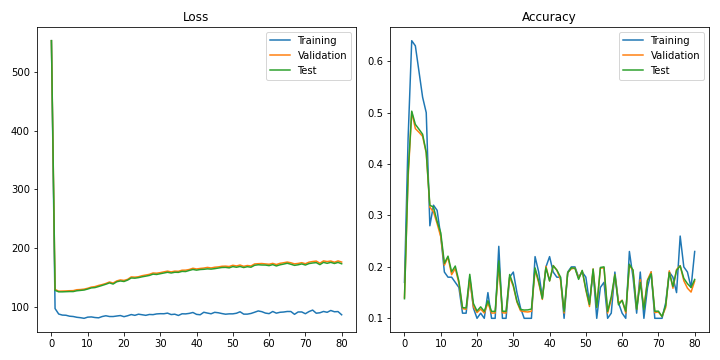

Training Loss: 86.367, Validation Loss: 176.086, Test Loss: 173.173
Training Accuracy: 0.230, Validation Accuracy: 0.173, Test Accuracy: 0.176
Epochs:  80


In [ ]:
%%time
# Instantiate VAE
sample = binarized_mnist_train_data.__getitem__(22)[0]
M2_instance = M2_VAE(input_shape = sample.flatten().shape,
                     output_shape = sample.flatten().shape,
                     latent_features = 34,
                     classes = 10,
                     hidden_layers_mu = [400],
                     hidden_layers_sigma = [400],
                     hidden_layers_classification = [500, 250],
                     hidden_layers_decoder = [200],
                     dropout = 0.9)
# Instantiate trainer
trainer = M2_VAE_Trainer(M2_instance,
                         binarized_mnist_train_loader_labelled,
                         binarized_mnist_train_loader_unlabelled,
                         binarized_mnist_train_loader_validation,
                         binarized_mnist_test_loader,
                         1,
                         0.1)
# Training
trainer.test()
while True:
    trainer.train()
    trainer.test()
    torch.save(M2_instance.state_dict(), fn)

**M2 - 5-DIMENSIONAL LATENT SPACE**

This model is trained just to have a model with a lower latent dimensionality for more interesting traversal.

In [ ]:
%%time
loader_setup(labelled_size=50000, unlabelled_size=0)
epochs = 20
fn = "m2_class_5D_latent.pt"
# Instantiate VAE
sample = binarized_mnist_train_data.__getitem__(22)[0]
M2_instance = M2_VAE(input_shape = sample.flatten().shape,
                     latent_features = 5,
                     classes = 10,
                     hidden_layers_preclass = [300],
                     hidden_layers_postclass = [200],
                     hidden_layers_classification = [500, 250],
                     hidden_layers_decoder = [200, 400],
                     dropout = 0.9)
# Instantiate trainer
trainer = M2_VAE_Trainer(M2_instance,
                         binarized_mnist_train_loader_labelled,
                         binarized_mnist_train_loader_unlabelled,
                         binarized_mnist_train_loader_validation,
                         binarized_mnist_test_loader,
                         5,
                         0.5)
# Training
if use_saved_models and os.path.isfile(fn):
    M2_instance.load_state_dict(torch.load(fn))
    print("Loaded model from %s" % fn)
    trainer.test()
else:
    trainer.test()
    for i in range(epochs):
        trainer.train()
        trainer.test()
    torch.save(M2_instance.state_dict(), fn)

## M2 Generative Exploration

Run any M2 configuration cell and the loading/training cell above to ensure that M2_instance references the desired model. Then run the cells below to generate visualizations.

**STYLE TRANSFER - LATENT REPRESENTATION ENCODED FROM OBSERVATION**

In [ ]:
# Style Transfer
M2_instance.eval()
#a = random.choices(binarized_mnist_train_data,k=10)
a = random.choices(mnist_train_data,k=10)
b = [x[0] for x in a]
img = torch.stack(b)
b = [x[1] for x in a]
lbl = torch.Tensor(b)
fig, axs = plt.subplots(10, 11, figsize=(10, 10), squeeze=False)

outputs = M2_instance(img, lbl)
z = outputs['z']

for i in range(len(img)):
    axs[i, 0].imshow(img[i], cmap='gray')
    axs[i, 0].axis('off')
    for j in range(10):
        image = M2_instance.decode(z[i].reshape(1, -1),
                                   M2_instance.onehot(torch.Tensor([j]).int())
                                  ).probs.view(28,28).cpu().detach().numpy()
        axs[i, j + 1].imshow(image, cmap='gray')
        axs[i, j + 1].axis('off')
plt.tight_layout()

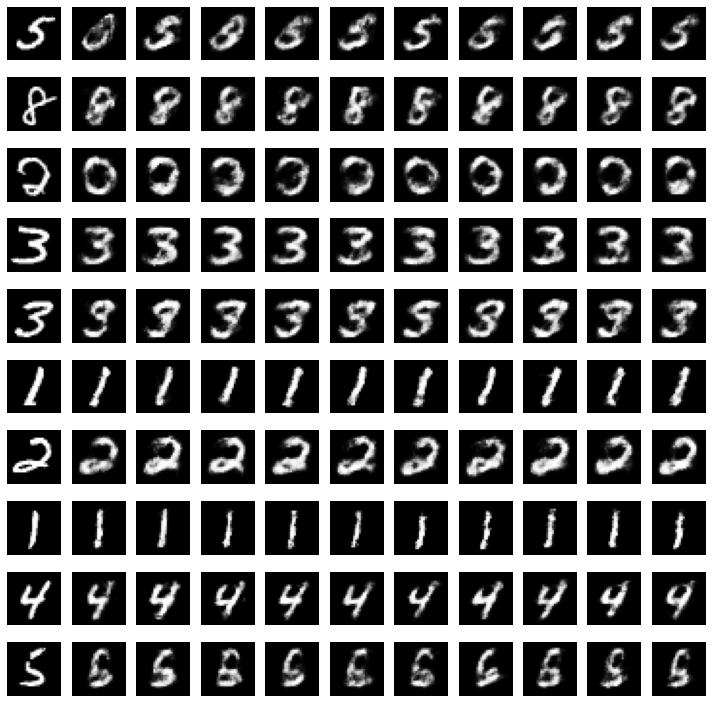

In [29]:
M2_instance.eval()
a = random.choices(mnist_train_data,k=10)
b = [x[0] for x in a]
img = torch.stack(b)
fig, axs = plt.subplots(10, 11, figsize=(10, 10), squeeze=False)
for i in range(len(img)):
    axs[i, 0].imshow(img[i], cmap='gray')
    axs[i, 0].axis('off')
    for j in range(10):
        lbl = torch.Tensor(10).fill_(j)
        outputs = M2_instance(img, lbl)
        px = outputs['px']
        image = px.probs[i].view(28,28).cpu().detach().numpy()
        axs[i, j + 1].imshow(image, cmap='gray')
        axs[i, j + 1].axis('off')
plt.tight_layout()

**LATENT TRAVERSAL - SPECIFIC DIGITS, TRAVERSING MULTIPLE AXIS**

In [ ]:
# Latent space traversal
x_dimension = 0
y_dimension = 1
traversal_speed = 0.5
digit = 4

M2_instance.eval()
fig, axs = plt.subplots(11, 11, figsize=(11, 11), squeeze=False)
latent_size = int(M2_instance.prior_params[0].size()[0] / 2)
z = torch.zeros(11, latent_size).cuda()
for i in range(11):
    z[i, x_dimension] = (i-5) * traversal_speed
for i in range(11):
    for j in range(11):
        z[j, y_dimension] = (i-5) * traversal_speed
    for j in range(11):
        image = M2_instance.decode(z[j].reshape(1, -1),
                                   M2_instance.onehot(torch.Tensor([digit]).int())
                                  ).probs.view(28,28).cpu().detach().numpy()
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()

**LATENT TRAVERSAL - ALL DIGITS ALONG DIAGONAL**

In [ ]:
# Latent space traversal
traversal_speed = 0.5

M2_instance.eval()
fig, axs = plt.subplots(10, 10, figsize=(10, 10), squeeze=False)
outputs = M2_instance(img, lbl)
latent_size = int(M2_instance.prior_params[0].size()[0] / 2)
z = torch.Tensor(11, latent_size).cuda() # Plotting from 11 points in 5-dimensional latent space
for i in range(11):
    for j in range(5):
        z[i, j] = (i-5) * traversal_speed
for i in range(10):
    axs[i, 0].axis('off')
    for j in range(10):
        image = M2_instance.decode(z[i].reshape(1, -1), 
                                   M2_instance.onehot(torch.Tensor([j]).int())
                                  ).probs.view(28,28).cpu().detach().numpy()
        axs[i, j].imshow(image, cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()

# Results

## FF

**FF 100 LABELLED - RESULT**

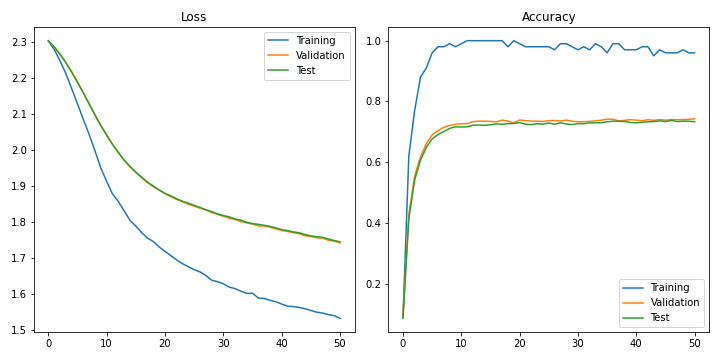
Training Accuracy: 0.960, Validation Accuracy: 0.743, Test Accuracy: 0.733

**FF 1K LABELLED - RESULT**

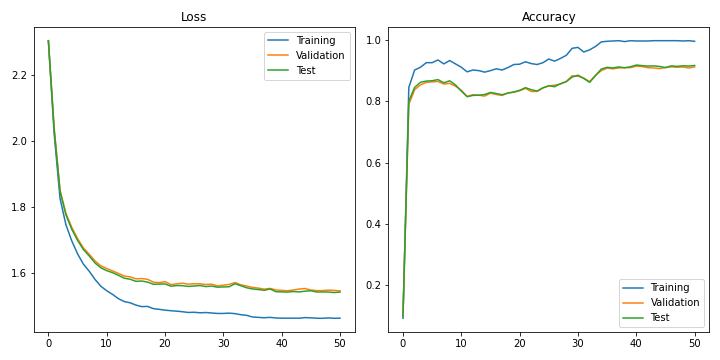
Training Accuracy: 0.997, Validation Accuracy: 0.913, Test Accuracy: 0.918

**FF 10K LABELLED - RESULT**

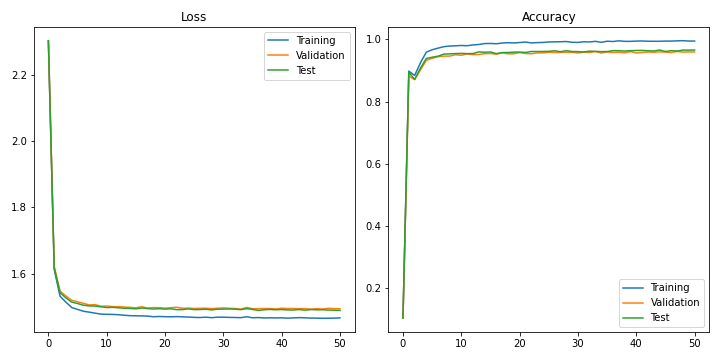
Training Accuracy: 0.995, Validation Accuracy: 0.959, Test Accuracy: 0.966

**FF 50K LABELLED - RESULT**

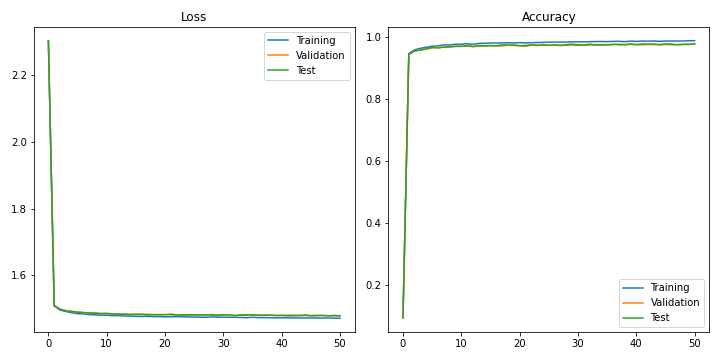
Training Accuracy: 0.988, Validation Accuracy: 0.976, Test Accuracy: 0.978

## M1

**M1 100/0 LABELLED/UNLABELLED OBSERVATIONS - RESULT**

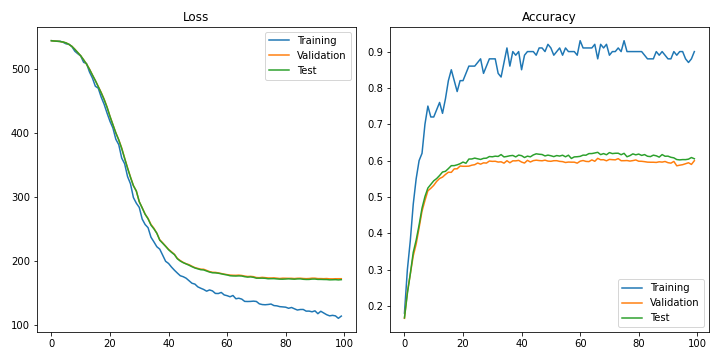
Training Accuracy: 0.900, Validation Accuracy: 0.600, Test Accuracy: 0.605

**M1 100/100 LABELLED/UNLABELLED OBSERVATIONS - RESULT**

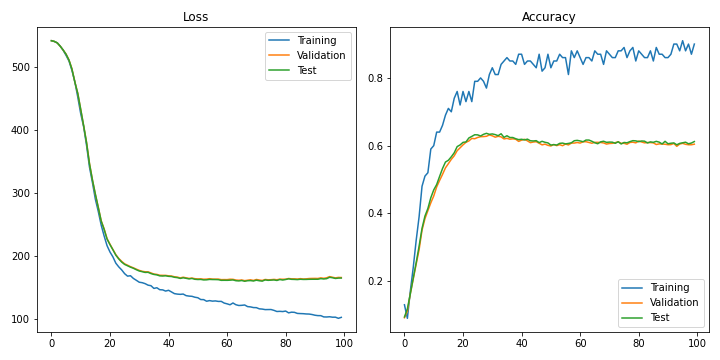
Training Accuracy: 0.900, Validation Accuracy: 0.604, Test Accuracy: 0.612

**M1 100/1K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

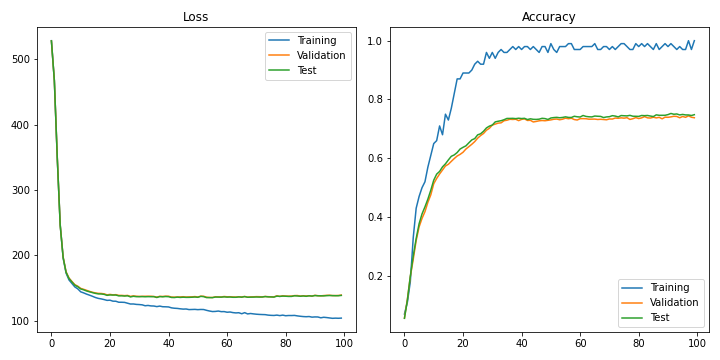
Training Accuracy: 1.000, Validation Accuracy: 0.738, Test Accuracy: 0.748

**M1 100/10K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

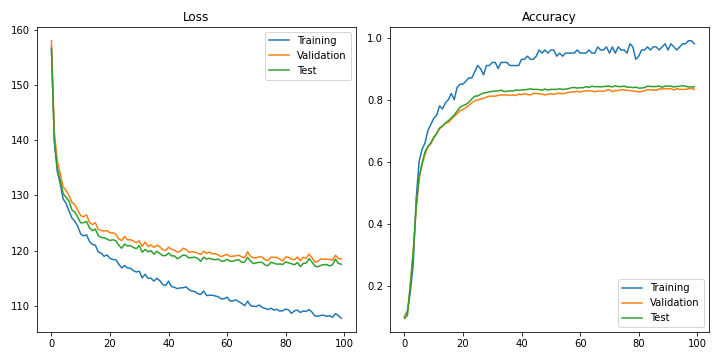
Training Accuracy: 0.980, Validation Accuracy: 0.834, Test Accuracy: 0.842

**M1 40K UNLABELLED VAE CORE TRAINING**

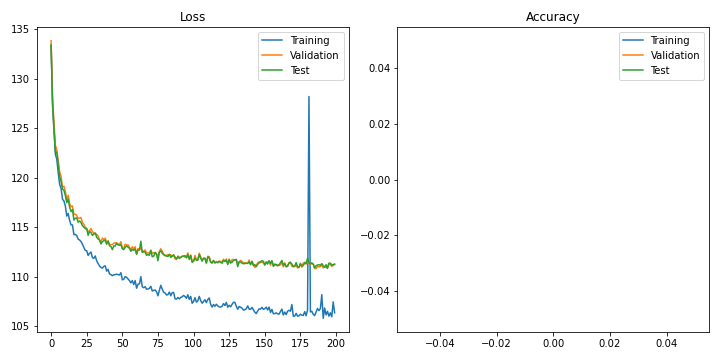

**M1 100/40K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

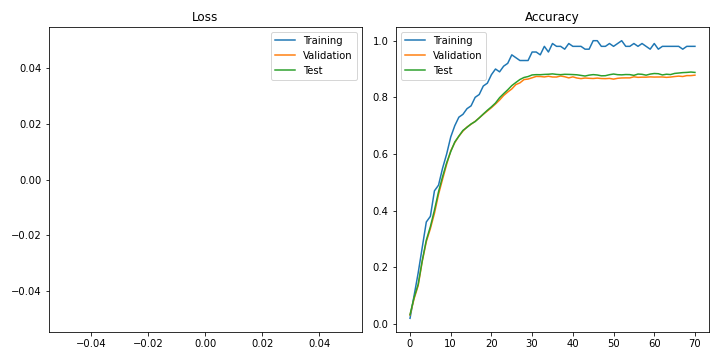
Training Accuracy: 0.980, Validation Accuracy: 0.878, Test Accuracy: 0.888

**M1 1K/40K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

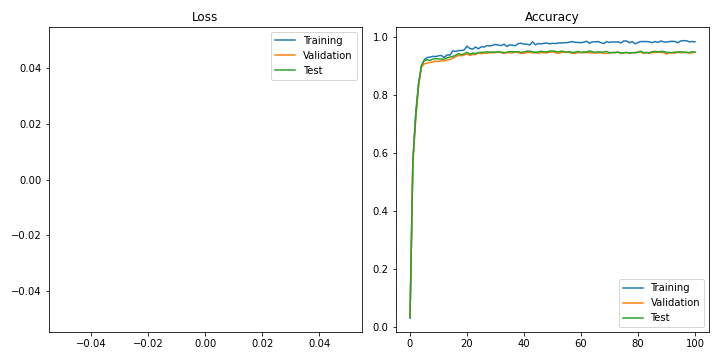
Training Accuracy: 0.983, Validation Accuracy: 0.948, Test Accuracy: 0.948

**M1 10K/40K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

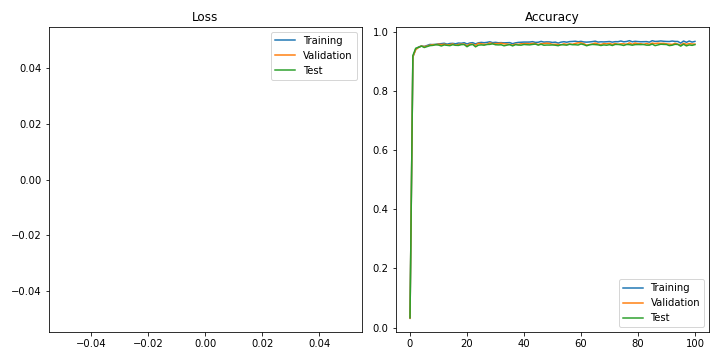
Training Accuracy: 0.968, Validation Accuracy: 0.959, Test Accuracy: 0.957

**M1 50K/40K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

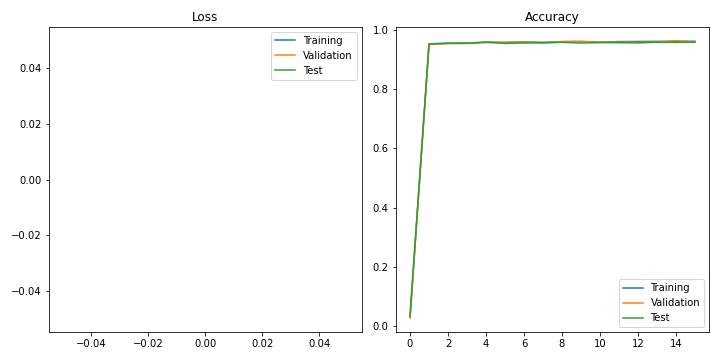
Training Accuracy: 0.962, Validation Accuracy: 0.959, Test Accuracy: 0.959

## M2

**M2 100/0 LABELLED/UNLABELLED OBSERVATIONS - RESULT**

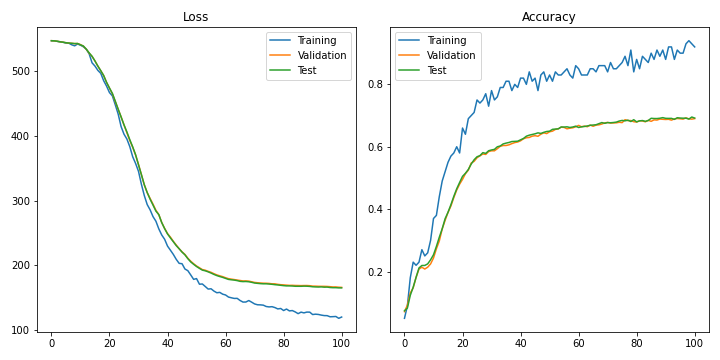
Training Accuracy: 0.920, Validation Accuracy: 0.690, Test Accuracy: 0.692

**M2 100/100 LABELLED/UNLABELLED OBSERVATIONS - RESULT**

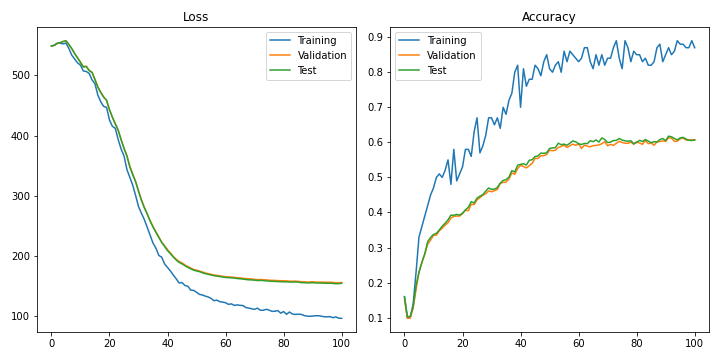
Training Accuracy: 0.870, Validation Accuracy: 0.608, Test Accuracy: 0.607

**M2 100/1K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

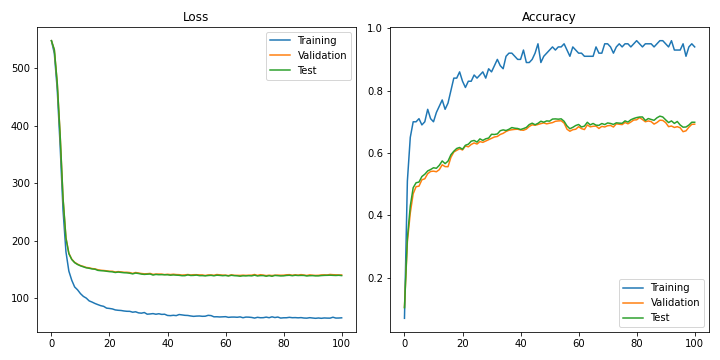
Training Accuracy: 0.940, Validation Accuracy: 0.692, Test Accuracy: 0.699

**M2 100/10K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

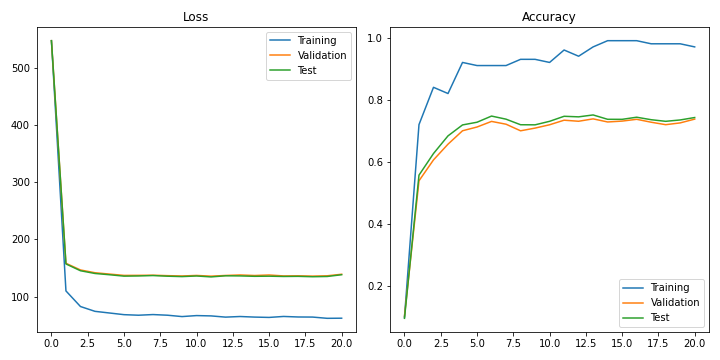
Training Accuracy: 0.970, Validation Accuracy: 0.738, Test Accuracy: 0.743

**M2 100/40K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

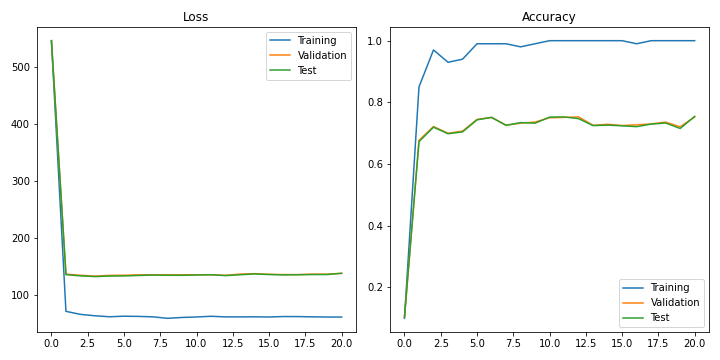
Training Accuracy: 1.000, Validation Accuracy: 0.753, Test Accuracy: 0.755

**M2 1K/40K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

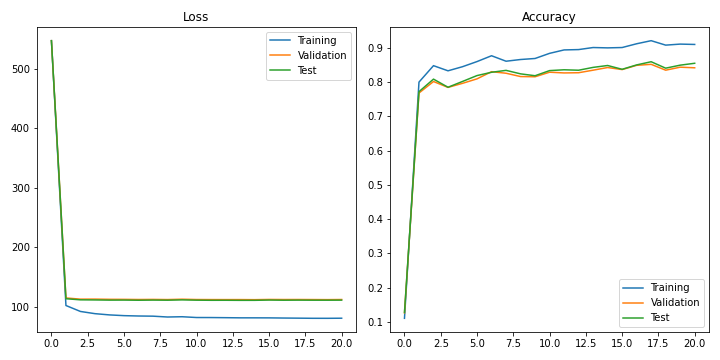
Training Accuracy: 0.910, Validation Accuracy: 0.842, Test Accuracy: 0.855

**M2 10K/40K LABELLED/UNLABELLED OBSERVATIONS - RESULT**

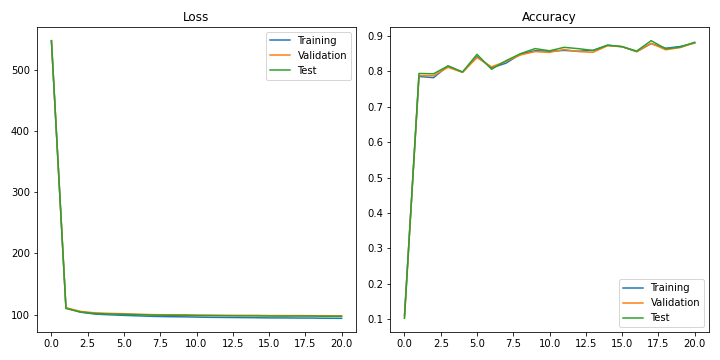
Training Accuracy: 0.880, Validation Accuracy: 0.881, Test Accuracy: 0.882

**M2 50K LABELLED OBSERVATIONS - RESULT**

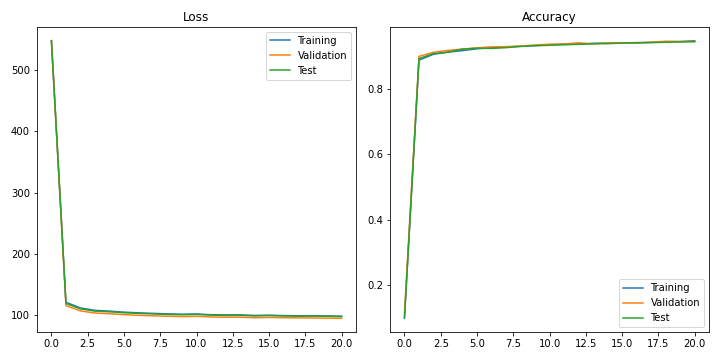
Training Accuracy: 0.949, Validation Accuracy: 0.947, Test Accuracy: 0.945

# Conclusion

**CLASSIFICATION PERFORMANCE COMPARISON - 100 LABELLED OBSERVATIONS**

In [ ]:
labels = ['0', '100', '1000', '10000', '40000']
ff_accuracies = [73.3, 73.3, 73.3, 73.3, 73.3]
m1_accuracies = [60.5, 60.7, 74.8, 84.2, 88.8]
m2_accuracies = [69.2, 63.8, 69.9, 74.3, 75.3]

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, ff_accuracies, width, label='FF')
rects2 = ax.bar(x, m1_accuracies, width, label='M1 VAE')
rects3 = ax.bar(x + width, m2_accuracies, width, label='M2 VAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Unlabelled Observations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()